In [1]:
using Random
using Distributions
using KernelDensity
include("../Inversion/GMNVI.jl")
include("../Inversion/Plot.jl")
include("../Inversion/DF_GMVI.jl")
include("../Inversion/GMBBVI.jl")
include("./MultiModal.jl")
Random.seed!(111);

## Gaussian likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
A \theta
+\eta \quad (A = I)
\qquad 
y = 
\begin{bmatrix}
0.0\\
1.0
\end{bmatrix} 
\qquad
\Sigma_{\eta} = I 
\end{align*}
$$


We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}F^TF}$ with 

$$F(\theta) = \frac{y - A \theta}{\sigma_\eta}$$

     

## Circle shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\theta^T A \theta
+\eta \quad (A = I)
\qquad 
y = 1
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
\sigma_\eta^2 
\end{bmatrix} 
\end{align*} (\sigma_\eta = 0.3)
$$


We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}F^TF}$ with 

$$F(\theta) = \frac{y - \theta^T A \theta}{\sigma_\eta}$$

     
     
## Banana shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\begin{bmatrix}
\lambda(\theta_{(2)} -  \theta_{(1)}^2)\\
\theta_{(1)}
\end{bmatrix}
+\eta \quad (\lambda = 100)
\qquad 
y = 
\begin{bmatrix}
0\\
1
\end{bmatrix}
\qquad
\Sigma_{\eta} = 
\sigma_\eta^2 I \qquad (\sigma_\eta = 0.3)
\end{align*}
$$

We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}F^TF}$ with 
$$F(\theta) = 
\begin{bmatrix}
\frac{y_{(1)} - \lambda(\theta_{(2)} -  \theta_{(1)}^2)}{\sigma_\eta}\\
\frac{y_{(2)} - \theta_{(1)}}{\sigma_\eta}
\end{bmatrix}$$
     
     
## Double banana shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\begin{bmatrix}
\log\Bigl(
\lambda(\theta_{(2)} -  \theta_{(1)}^2)^2 + (1 - \theta_{(1)})^2
\Bigr)\\ 
\theta_{(1)}\\ 
\theta_{(2)}
\end{bmatrix}
+ \eta \quad(\lambda = 100)
\qquad 
y = 
\begin{bmatrix}
\log(\lambda+1)\\
0\\
0
\end{bmatrix}
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
\sigma_\eta^2 & \\
& 1^2   \\
& & 1^2
\end{bmatrix}  
\end{align*}
$$

We essentially focus on the prior $\mathcal{N}(0,I)$, and we are sampling 
$e^{-\frac{1}{2}F^TF}$ 
with 
$$F(\theta) = 
\begin{bmatrix}
\frac{y_{(1)} - \log\Bigl(
\lambda(\theta_{(2)} -  \theta_{(1)}^2)^2 + (1 - \theta_{(1)})^2
\Bigr)}{\sigma_\eta}\\
y_{(2)} - \theta_{(1)}\\
y_{(3)} - \theta_{(2)}
\end{bmatrix}$$

In [2]:
function Gaussian_mixture_NGFVI(func_V, w0, μ0, Σ0; diagonal_covariance::Bool = false,  Hessian_correct_GM::Bool = false, N_ens = -1, N_ens_GM = -1, N_iter = 100, dt = 1.0e-3)

    N_modes, N_θ = size(μ0)
    
    if N_ens == -1  N_ens = 2*N_θ+1   end

    T =  N_iter * dt
    x0_w = w0
    x0_mean = μ0
    xx0_cov = Σ0
    sqrt_matrix_type = "Cholesky"
    
    objs = []

    gmnviobj = GMNVI_Run(
    func_V, 
    T,
    N_iter,
    # Initial condition
    x0_w, x0_mean, xx0_cov;
    sqrt_matrix_type = sqrt_matrix_type,
    diagonal_covariance = diagonal_covariance,
    # setup for Gaussian mixture part
    quadrature_type_GM = "mean_point",
    # setup for potential function part
    quadrature_type = "mean_point",
    Hessian_correct_GM = Hessian_correct_GM,
    N_ens = N_ens)
    
    push!(objs, gmnviobj)


    return objs
end



function visualization_comparison_2d(ax, obj_GMNVI, obj_DFGMVI, obj_BBVI, obj_GMWVI, ens_MCMC; Nx = 200, Ny = 200, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0],
        func_F = nothing, func_Phi = nothing, bandwidth=nothing, make_label::Bool=false, N_iter=500)

        # @assert length(obj_GMWVI)==length(obj_GMNVI)==size(ens_MCMC,2)

        # N_iter=maximum(length(obj_GMNVI)-1,length(obj_GMWVI)-1,size(ens_MCMC,2)-1)

        x_min, x_max = x_lim
        y_min, y_max = y_lim

        xx = LinRange(x_min, x_max, Nx)

        yy = LinRange(y_min, y_max, Ny)
        dx, dy = xx[2] - xx[1], yy[2] - yy[1]
        X,Y = repeat(xx, 1, Ny), repeat(yy, 1, Nx)'

        Z_ref = (func_Phi === nothing ? posterior_2d(func_F, X, Y, "func_F") : posterior_2d(func_Phi, X, Y, "func_Phi"))
        color_lim = (minimum(Z_ref), maximum(Z_ref))
        ax[1].pcolormesh(X, Y, Z_ref, cmap="viridis", clim=color_lim)

        error = zeros(5, N_iter+1)

        #NGF-VI
        if obj_GMNVI!=nothing
                for iter = 0:N_iter
                x_w = exp.(obj_GMNVI.logx_w[iter+1]); x_w /= sum(x_w)
                x_mean = obj_GMNVI.x_mean[iter+1][:,1:2]
                xx_cov = obj_GMNVI.xx_cov[iter+1][:,1:2,1:2]
                Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
                error[1, iter+1] = norm(Z - Z_ref,1)*dx*dy
                
                if iter == N_iter
                
                        ax[2].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                        # N_modes = size(x_mean, 1)
                        ax[2].scatter([obj_GMNVI.x_mean[1][:,1];], [obj_GMNVI.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                        ax[2].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)
                
                end
                end
        end

        #DFGMVI
        if obj_DFGMVI!=nothing
                for iter = 0:N_iter
                x_w = exp.(obj_DFGMVI.logx_w[iter+1]); x_w /= sum(x_w)
                x_mean = obj_DFGMVI.x_mean[iter+1][:,1:2]
                xx_cov = obj_DFGMVI.xx_cov[iter+1][:,1:2,1:2]
                Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
                error[2, iter+1] = norm(Z - Z_ref,1)*dx*dy
                
                if iter == N_iter
                
                        ax[3].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                        # N_modes = size(x_mean, 1)
                        ax[3].scatter([obj_DFGMVI.x_mean[1][:,1];], [obj_DFGMVI.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                        ax[3].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)
                
                end
                end
        end



        #GMBBVI
        if obj_BBVI !=nothing
                for iter = 0:N_iter
                x_w = exp.(obj_BBVI.logx_w[iter+1]); x_w /= sum(x_w)
                x_mean = obj_BBVI.x_mean[iter+1][:,1:2]
                xx_cov = obj_BBVI.xx_cov[iter+1][:,1:2,1:2]
                Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
                error[4, iter+1] = norm(Z - Z_ref,1)*dx*dy
                
                if iter == N_iter
                
                        ax[4].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                        ax[4].scatter([obj_BBVI.x_mean[1][:,1];], [obj_BBVI.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                        ax[4].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)
                
                end
                end
        end

        #GMWVI
        if obj_GMWVI!=nothing
                for iter = 0:N_iter
                x_w = exp.(obj_GMWVI.logx_w[iter+1]); x_w /= sum(x_w)
                x_mean = obj_GMWVI.x_mean[iter+1][:,1:2]
                xx_cov = obj_GMWVI.xx_cov[iter+1][:,1:2,1:2]
                Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
                error[3, iter+1] = norm(Z - Z_ref,1)*dx*dy
                
                if iter == N_iter
                
                        ax[5].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                        ax[5].scatter([obj_GMWVI.x_mean[1][:,1];], [obj_GMWVI.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                        ax[5].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)
                
                end
                end
        end

        #MCMC
        if ens_MCMC!=nothing
                boundary=((x_lim[1],x_lim[2]),(y_lim[1],y_lim[2]))
                for iter = 0:N_iter

                if bandwidth==nothing
                        kde_iter=kde(ens_MCMC[:,:,iter+1]';boundary=boundary,npoints=(Nx,Ny))
                else
                        kde_iter=kde(ens_MCMC[:,:,iter+1]';boundary=boundary,npoints=(Nx,Ny),bandwidth=bandwidth)
                end

                Z = kde_iter.density/(sum(kde_iter.density)*dx*dy)
                error[5, iter+1] = norm(Z - Z_ref,1)*dx*dy
                
                if iter == N_iter
                        
                        last_n_iters=10  #use the last "last_n_iters" iterations to draw pictures
                        last_ens=hcat([ens_MCMC[:,:,i] for i in N_iter+2-last_n_iters:N_iter+1]...)
                        last_ens_number=size(last_ens,2)

                        if bandwidth==nothing
                        kde_last=kde(last_ens'; boundary=boundary, npoints=(Nx,Ny))
                        else
                        kde_last=kde(last_ens'; boundary=boundary, npoints=(Nx,Ny), bandwidth=bandwidth)
                        end

                        Z = kde_last.density/(sum(kde_last.density)*dx*dy)

                        ax[6].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                        ax[6].scatter(last_ens[1,:], last_ens[2,:], marker=".", color="red", s=10, alpha=100/last_ens_number)
                        ax[6].set_xlim(x_lim)
                        ax[6].set_ylim(y_lim)

                        end
                end
        end

        ax[7].semilogy(Array(0:N_iter), error', label=["NGF-VI","DFGMVI","BBVI","NGF-VI-D","MCMC"])   

        if make_label==true
                ax[7].legend()
        end

        # Get the current y-axis limits
        ymin, ymax = ax[7].get_ylim()
        # Ensure the lower bound of y-ticks is below 0.1
        if ymin > 0.1
                ax[7].set_ylim(0.1, ymax)  # Set the lower limit to a value below 0.1
        end

end

visualization_comparison_2d (generic function with 1 method)

# Test the aforementioned examples with different methods

[ Info: ("iter = ", 10, " / ", 100)
[ Info: ("iter = ", 20, " / ", 100)
[ Info: ("iter = ", 30, " / ", 100)
[ Info: ("iter = ", 40, " / ", 100)
[ Info: ("iter = ", 50, " / ", 100)
[ Info: ("iter = ", 60, " / ", 100)
[ Info: ("iter = ", 70, " / ", 100)
[ Info: ("iter = ", 80, " / ", 100)
[ Info: ("iter = ", 90, " / ", 100)
[ Info: ("iter = ", 100, " / ", 100)
[ Info: ("iter = ", 10, " / ", 100)
[ Info: ("iter = ", 20, " / ", 100)
[ Info: ("iter = ", 30, " / ", 100)
[ Info: ("iter = ", 40, " / ", 100)
[ Info: ("iter = ", 50, " / ", 100)
[ Info: ("iter = ", 60, " / ", 100)
[ Info: ("iter = ", 70, " / ", 100)
[ Info: ("iter = ", 80, " / ", 100)
[ Info: ("iter = ", 90, " / ", 100)
[ Info: ("iter = ", 100, " / ", 100)
[ Info: ("iter = ", 10, " / ", 100)
[ Info: ("iter = ", 20, " / ", 100)
[ Info: ("iter = ", 30, " / ", 100)
[ Info: ("iter = ", 40, " / ", 100)
[ Info: ("iter = ", 50, " / ", 100)
[ Info: ("iter = ", 60, " / ", 100)
[ Info: ("iter = ", 70, " / ", 100)
[ Info: ("iter = ", 80, " 

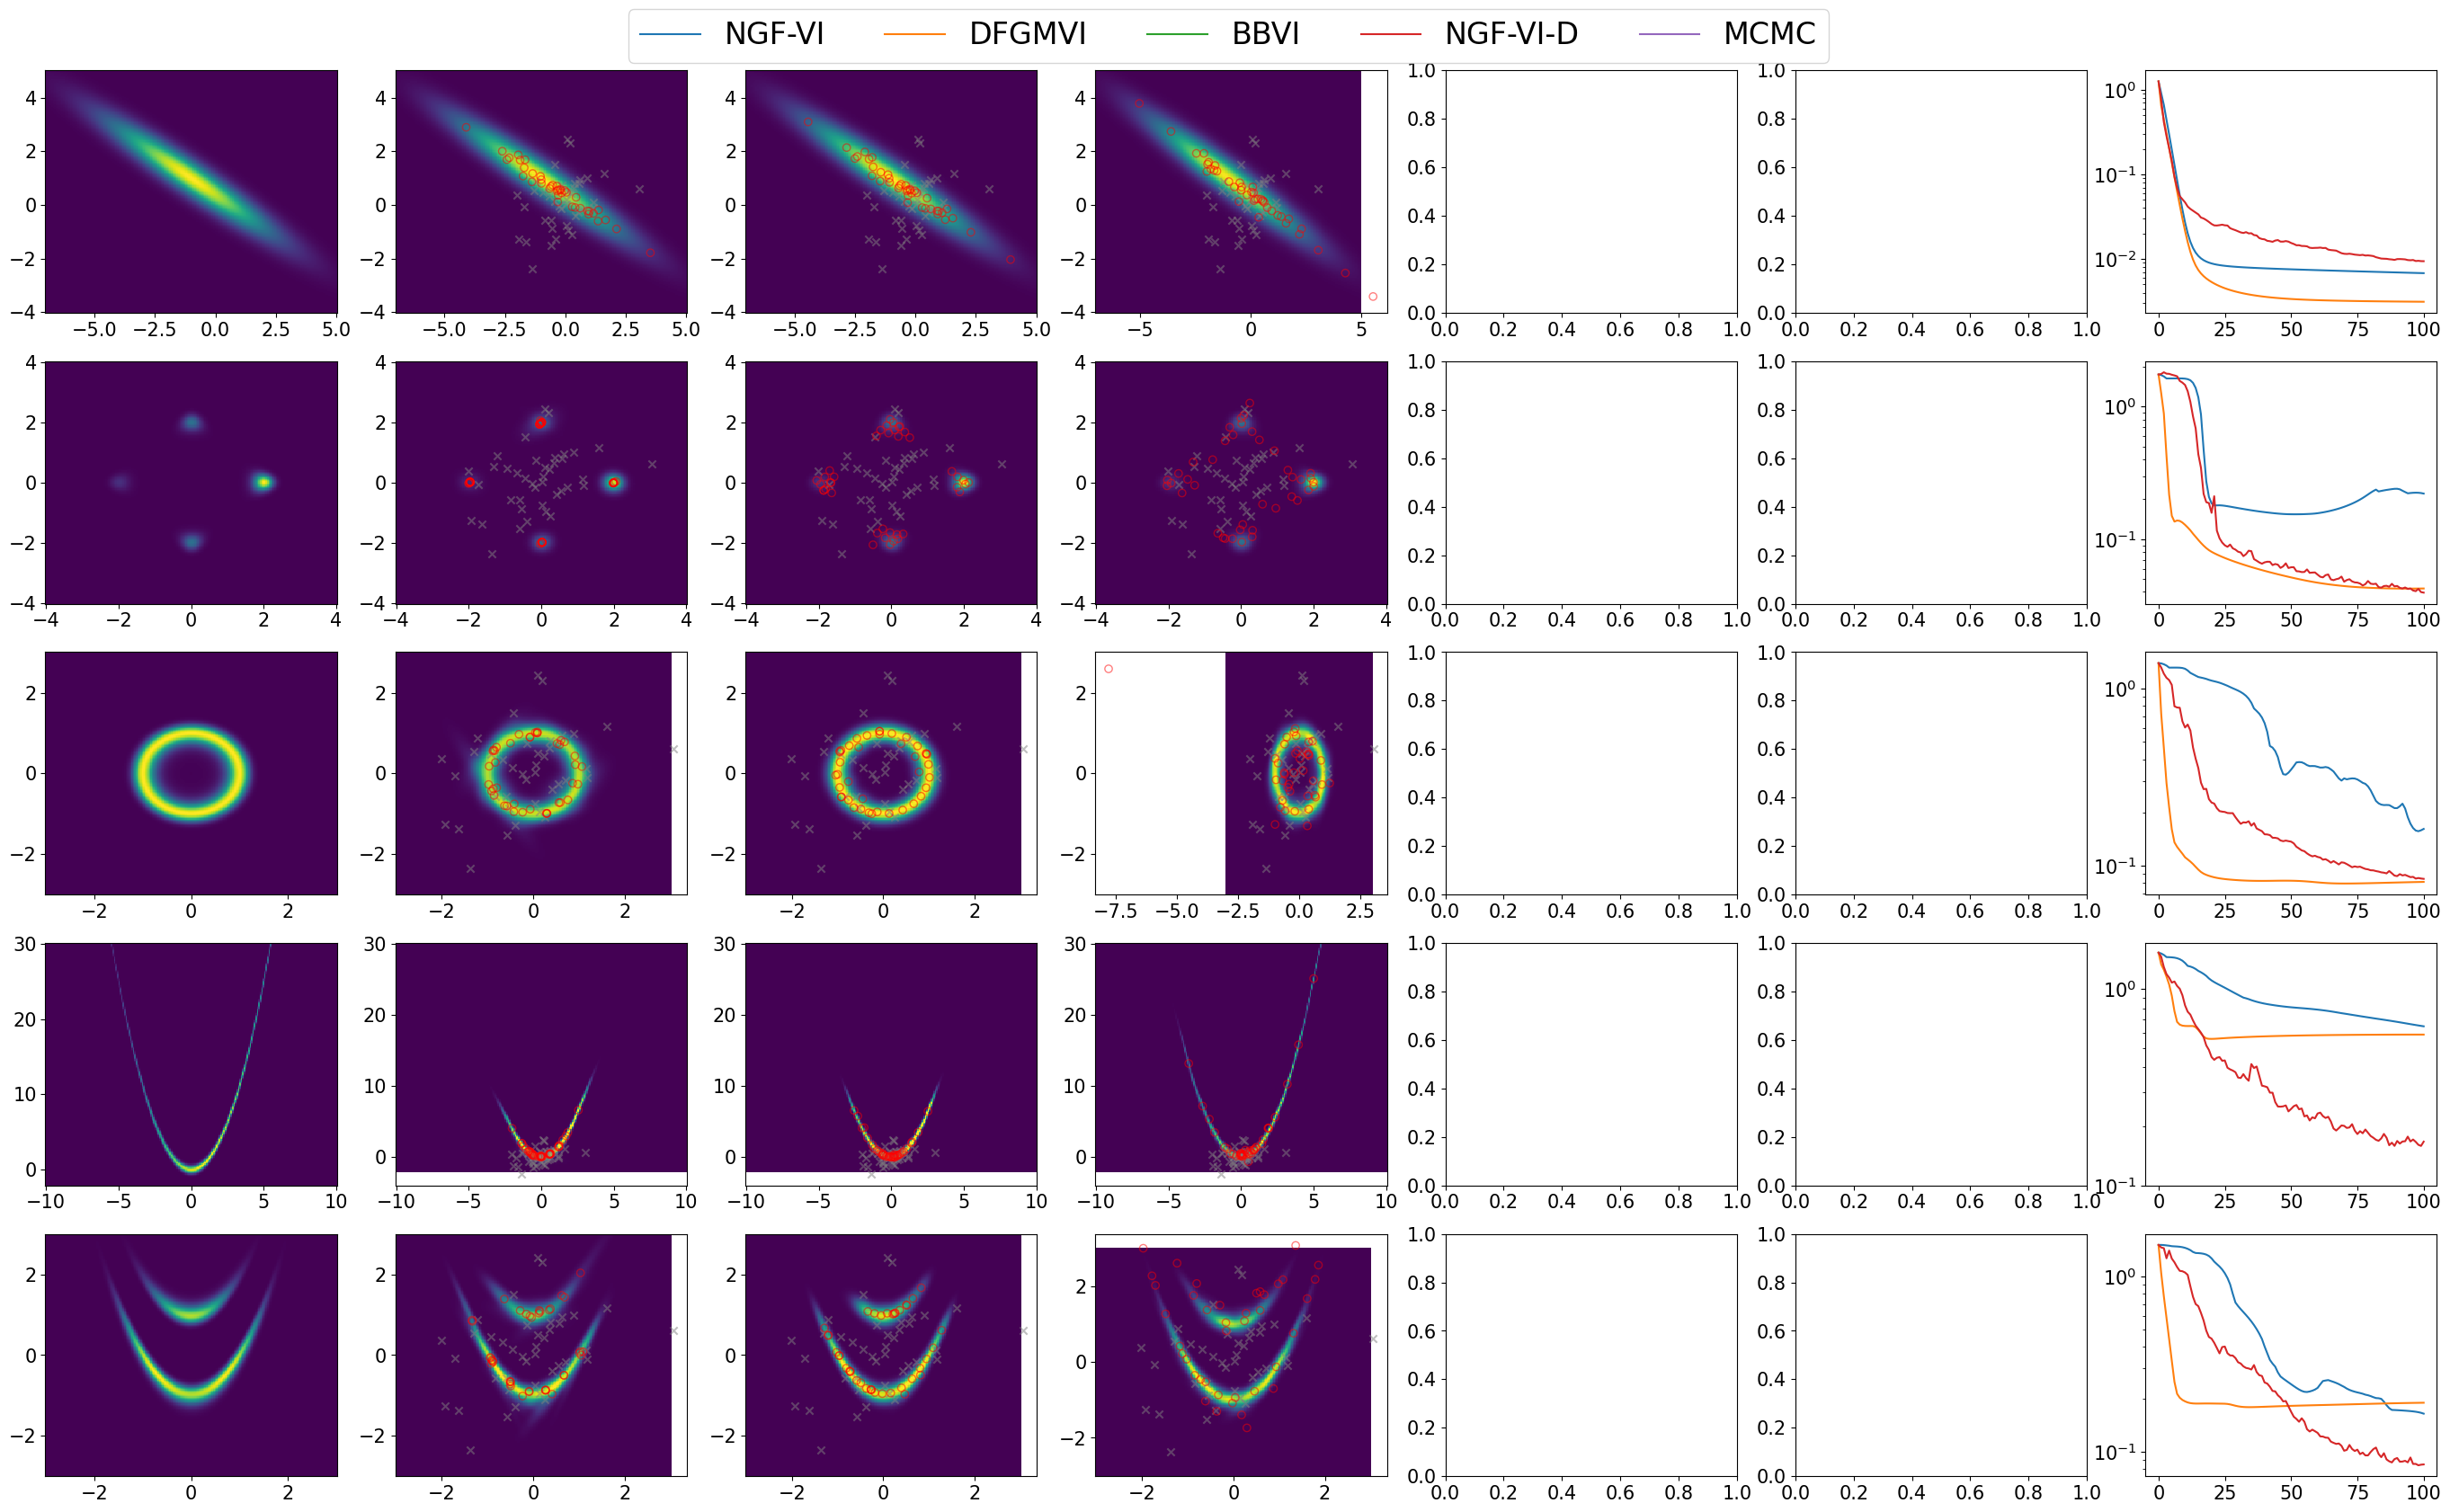

In [3]:
# Test the examples in MultiModal-DFGMVI.ipynb with different methods

include("../Inversion/GMBBVI.jl")


N_modes = 40 # number of modes in Gaussian mixture
N_ens= 1000 # number of paticles in MCMC
N_bbvi_sample = 5 # number of samples to compute expectation using Monte Carlo in BBVI

fig, ax = PyPlot.subplots(nrows=5, ncols=7, sharex=false, sharey=false, figsize=(28,17))


Random.seed!(111);
x0_w  = ones(N_modes)/N_modes
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
N_x = length(μ0)
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
for im = 1:N_modes
    x0_mean[im, :]    .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
    xx0_cov[im, :, :] .= Σ0
end
Hessian_correct_GM = false
ens_0=zeros(N_x,N_ens)
for j = 1:N_ens
    ens_0[:,j]  = rand(MvNormal(zeros(N_x), Σ0)) + μ0
end

N_iter = 100
Nx, Ny = 200,200



ση = 1.0
Gtype = "Gaussian"
dt1 = dt3 = dt4 = 0.5
dt2 = 1.4e-1 
A = [1.0 1.0; 1.0 2.0]
y = [0.0; 1.0; zeros(N_x-2)]
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
func_prob(x)=exp(logrho(x, func_args))
func_Phi(x)= -logrho(x, func_args)

obj_NGFlow = Gaussian_mixture_NGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; diagonal_covariance = false, N_iter = N_iter, dt = dt1, Hessian_correct_GM=true)[1]
obj_DFGMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt1)[1]
obj_BBVI = Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt4, N_ens=N_bbvi_sample)

visualization_comparison_2d(ax[1,:], obj_NGFlow, obj_DFGMVI, obj_BBVI, nothing, nothing ; Nx = Nx, Ny = Ny, x_lim=[-7.0, 5.0], y_lim=[-4.0, 5.0], func_F=func_F, 
    bandwidth=(0.32,0.22), make_label=false,  N_iter= N_iter)



ση = 1.0
Gtype = "Four_modes"
dt1 = dt3 = dt4 = 0.5
dt2 = 5e-3
y = [4.2297; 4.2297; 0.5; 0.0; zeros(N_x-2)]
func_args = (y, ση, 0, Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
func_prob(x)=exp(logrho(x, func_args))
func_Phi(x)= -logrho(x, func_args)

obj_NGFlow = Gaussian_mixture_NGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; diagonal_covariance = false, N_iter = N_iter, dt = dt1, Hessian_correct_GM=Hessian_correct_GM)[1]
obj_DFGMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt1)[1]
obj_BBVI = Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt4, N_ens=N_bbvi_sample)

visualization_comparison_2d(ax[2,:],  obj_NGFlow, obj_DFGMVI, obj_BBVI, nothing, nothing ; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-4, 4], func_F=func_F, 
    bandwidth=(0.14,0.14), make_label=false,  N_iter= N_iter)



ση = [0.3; ones(N_x-2)]
Gtype = "Circle"
dt1 = dt3 = dt4 = 0.5
dt2 = 5e-3
A = [1.0 0.0; 0.0 1.0]
y = [1.0; zeros(N_x-2)]
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
func_prob(x)=exp(logrho(x, func_args))
func_Phi(x)= -logrho(x, func_args)

obj_NGFlow = Gaussian_mixture_NGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; diagonal_covariance = false, N_iter = N_iter, dt = dt1, Hessian_correct_GM=Hessian_correct_GM)[1]
obj_DFGMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt1)[1]
obj_BBVI = Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt4, N_ens=N_bbvi_sample)

visualization_comparison_2d(ax[3,:], obj_NGFlow, obj_DFGMVI, obj_BBVI, nothing, nothing ; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F, 
    bandwidth=(0.20,0.14), make_label=false,  N_iter= N_iter)



ση = [sqrt(10.0); sqrt(10.0); ones(N_x-2)]
Gtype = "Banana"
dt1 = dt3 = dt4 = 0.5
dt2 = 4e-3
λ = 10.0
y = [0.0; 1.0; zeros(N_x-2)]
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
func_prob(x)=exp(logrho(x, func_args))
func_Phi(x)= -logrho(x, func_args)

obj_NGFlow = Gaussian_mixture_NGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; diagonal_covariance = false, N_iter = N_iter, dt = dt1, Hessian_correct_GM=Hessian_correct_GM)[1]
obj_DFGMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt1)[1]
obj_BBVI = Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt4, N_ens=N_bbvi_sample)

visualization_comparison_2d(ax[4,:], obj_NGFlow, obj_DFGMVI, obj_BBVI, nothing, nothing ; Nx = Nx, Ny = Ny, x_lim=[-10.0, 10.0], y_lim=[-2.0, 30.0], func_F=func_F, 
    bandwidth=(0.06,0.11), make_label=false,  N_iter= N_iter)



ση = [0.3; 1.0; 1.0; ones(N_x-2)]
Gtype = "Double_banana"
dt1 = dt3 = dt4 = 0.5
dt2 = 8e-4
λ = 100.0
y = [log(λ+1); 0.0; 0.0; zeros(N_x-2)]
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
func_prob(x)=exp(logrho(x, func_args))
func_Phi(x)= -logrho(x, func_args)

obj_NGFlow = Gaussian_mixture_NGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; diagonal_covariance = false, N_iter = N_iter, dt = dt1, Hessian_correct_GM = Hessian_correct_GM)[1]
obj_DFGMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt1)[1]
obj_BBVI = Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt4, N_ens=N_bbvi_sample)

visualization_comparison_2d(ax[5,:], obj_NGFlow, obj_DFGMVI, obj_BBVI, nothing, nothing ; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F, 
    bandwidth=(0.06,0.11), make_label=false,  N_iter= N_iter)



handles, labels = ax[1, end].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncol=5,fontsize=24)
fig.subplots_adjust(bottom=0.03,top=0.95,left=0.03,right=0.98,hspace=0.2)

fig.savefig("MultiModal-Comparison-2D.pdf")
